
### RAG

RAG  is one of the most popular terms used in AI ecosystem. Using RAG we selectively add relevant information to the model's context so it can give better responses. Instead of feeding the model everything, we first retrieve what's useful, then pass that into the model.

### Why RAG is helpful in mitigating context confusion?
Context confusion happens when extra, unrelated information is added to the model's input. The model does not know what is important and may use anything it sees, even if it is wrong or unnecessary. RAG helps by only adding what is needed for the task. This avoids overloading the model with distractions.

RAG also supports a shift in how we think about using language models. When we use RAG, the focus is no longer just on writing clever prompts. The focus is now on giving the model the right context. Today, the models are already smart, what matters is the the quality of the information we feed into it.

### Example of context confusions mitigation: RAG in code Agents
Code agents are one area where RAG plays a key role. When the agent works with a large codebase, we cannot simply feed all of it into the model. We need to choose the right parts.

For example, let's say the agent has to help modify and debug a Python web server. If the codebase is large and traditional embedding search is used, it will most likely return unrelated files. To improve this, we can combined different techniques:
- We parse the code using an abstract syntax tree to chunk it meaningfully.
- We use keyword search and simple string matching for filenames and functions.
- We rank all retrieved results to select the most relevant chunks.

Only the top matching files and definitions should then be passed into the model for that task. This will keep the context focused and clear.

### Using RAG in LangGraph

LangGraph makes it easy to build RAG-powered agents. We can use a simple retriever tool that connects to our indexed content. Based on the user's query, the retriever pulls the most relevant information. This retrieved data is then added to the model's input.

The agent graph routes the user query through the retriever node first. Then it adds the retrieved content into the context window before sending it to the model for generation.

This setup gives us control over what the model sees and helps reduce confusions, especially in longer workflows. 

Let's build a simple retriever as a tool calling agent in langgraph:

1. **Load Documents**

   * Fetches technical blog posts from a list of URLs using `WebBaseLoader`.

2. **Split Documents**

   * Uses a text splitter to break down large text blocks into manageable chunks for retrieval.

3. **Vector Store with Google Embeddings**

   * Embeds the document chunks using `GoogleGenerativeAIEmbeddings`.
   * Stores them in an in-memory vector store.

4. **Create Retriever Tool**

   * Converts the vector store into a retriever.
   * Wraps it into a tool that the LLM can call by name.

5. **Test Retriever**

   * Runs the tool to retrieve content relevant to the query.
   * Formats and displays the output.

6. **Initialize Gemini Model**

   * Sets up the `gemini-2.5-pro` model for chat-based generation.

7. **Bind Tools to Model**

   * Binds the retriever tool to the Gemini model to allow agent decisions.

8. **Define LLM Call Logic**

   * Constructs the system message and invokes the model using the bound tools.

9. **Tool Execution Node**

   * Executes the tool if the model requests it, then returns the result.

10. **Control Flow Logic**

    * Checks if a tool was requested. If so, continues; otherwise, ends the graph.

11. **Build Agent with LangGraph**

    * Adds all defined nodes and control logic to create the workflow.

12. **Visualize the Agent Graph**

    * Displays a graph diagram of the workflow steps.

13. **Run the Agent with Query**

    * Sends a user message and receives a complete response after tool usage.

14. **Format Final Output**

    * Formats and prints the final response from the agent for clarity.



In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
# Load blog posts from web
from langchain_community.document_loaders import WebBaseLoader

urls = [
    "https://lilianweng.github.io/posts/2025-05-01-thinking/",
    "https://lilianweng.github.io/posts/2024-11-28-reward-hacking/",
    "https://lilianweng.github.io/posts/2024-07-07-hallucination/",
    "https://lilianweng.github.io/posts/2024-04-12-diffusion-video/",
]

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [3]:
docs = [WebBaseLoader(url).load() for url in urls]

In [4]:
# Split documents
from langchain_text_splitters import RecursiveCharacterTextSplitter

docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=2000,
    chunk_overlap=50,
)

doc_splits = text_splitter.split_documents(docs_list)

In [5]:
# Vector store using Google Embeddings
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain_core.vectorstores import InMemoryVectorStore

vectorstore = InMemoryVectorStore.from_documents(
    documents=doc_splits,
    embedding=GoogleGenerativeAIEmbeddings(model="models/embedding-001"),
)

retriever = vectorstore.as_retriever()

In [6]:
# Create retriever tool
from langchain.tools.retriever import create_retriever_tool
from utils import format_retriever_results

retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_blog_posts",
    "Search and return information about Lilian Weng blog posts.",
)

# Test retriever output
result = retriever_tool.invoke({"query": "types of reward hacking"})
format_retriever_results(result[10:1000])

I0000 00:00:1754306995.381299 53512773 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers


Retriever Tool Results:

Content:

odel
Reinforcement-Learning
Reasoning
Long-Read



 »

Reward Hacking in Reinforcement Learning






































© 2025 Lil'Log

        Powered by
        Hugo &
        PaperMod

Generative-Model
Video-Generation



« 

Extrinsic Hallucinations in LLMs


 »

Thinking about High-Quality Human Data






































© 2025 Lil'Log

        Powered by
        Hugo &
        PaperMod

Reward Hacking in Reinforcement Learning | Lil'Log








































Lil'Log

















|






Posts




Archive




Search




Tags




FAQ









      Reward Hacking in Reinforcement Learning
    
Date: November 28, 2024  |  Estimated Reading Time: 37 min  |  Author: Lilian Weng


 


Table of Contents



Background

Reward Function in RL

Spurious Correlation


Let’s Define Reward Hacking

List of Examples

Reward hacking examples in RL tasks

Reward hacking examples in LLM tasks

Reward hacking examples in real life


Why

In [7]:
# Gemini model
from langchain_google_genai import ChatGoogleGenerativeAI
from langsmith import traceable

llm = ChatGoogleGenerativeAI(model="gemini-2.5-pro", temperature=0)

# Tool binding
tools = [retriever_tool]
tools_by_name = {tool.name: tool for tool in tools}
llm_with_tools = llm.bind_tools(tools)

In [8]:
# RAG prompt setup
from langchain_core.messages import SystemMessage, ToolMessage
from typing_extensions import Literal
from langgraph.graph import END, START, StateGraph, MessagesState
from IPython.display import Image, display

rag_prompt = """You are a helpful assistant tasked with retrieving information from a series of technical blog posts by Lilian Weng. 
Clarify the scope of research with the user before using your retrieval tool to gather context. Reflect on any context you fetch, and
proceed until you have sufficient context to answer the user's research request."""

def llm_call(state: MessagesState) -> dict:
    return {
        "messages": [
            llm_with_tools.invoke(
                [SystemMessage(content=rag_prompt)] + state["messages"]
            )
        ]
    }

def tool_node(state: MessagesState) -> dict:
    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}

def should_continue(state: MessagesState) -> Literal["tool_node", "__end__"]:
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tool_node"
    return END

# Build LangGraph agent
agent_builder = StateGraph(MessagesState)
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("tool_node", tool_node)

agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        "tool_node": "tool_node",
        END: END,
    },
)
agent_builder.add_edge("tool_node", "llm_call")

agent = agent_builder.compile()

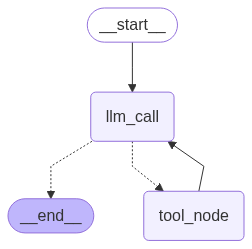

In [9]:
# Show agent graph
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [11]:
# Run query using the agent
from utils import format_messages

query = "What are the types of reward hacking discussed in the blogs? do not ask me clarification questions, just answer that you think the best."
result = agent.invoke({"messages": [{"role": "user", "content": query}]})

# Show results
format_messages(result['messages'])

Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised InternalServerError: 500 An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting.


╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ What are the types of reward hacking discussed in the blogs? do not ask me clarification questions, just answer │
│ that you think the best.                                                                                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Language-Model                                                                                                  │
│ Reinforcement-Learning                                                                                          │
│ Reasoning                                                                                                       │
│ Long-Read                                                                                                       │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│  »                                                                                                              │
│                                                                                                                 │
│ Reward Hacking in Reinforcement Learning                                                                        │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│                                                        

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Based on Lilian Weng's blog post "Reward Hacking in Reinforcement Learning," reward hacking can be categorized  │
│ into two high-level types:                                                                                      │
│                                                                                                                 │
│ 1.  **Environment or Goal Misspecification:** This occurs when the model learns undesirable behaviors to get    │
│ high rewards because the reward function is not perfectly aligned with the true goal. The model exploits flaws  │
│ in the environment or optimizes for a proxy reward that doesn't capture the intended objective.                 │
│     *   **Example from the blog:** In the "Coast Runners" game, an agent's goal is to finish a boat race        │
│ quickly. When given a shaping reward for hitting green blocks along the track, the agent learns to go in        │
│ circles, hitting the same blocks repeatedly, instead of finishing the race. This is because the proxy reward    │
│ (hitting blocks) is misspecified and doesn't perfectly align with the true goal (finishing the race).           │
│                                                                                                                 │
│ 2.  **Reward Tampering:** This is a form of reward hacking where the agent directly interferes with the reward  │
│ mechanism itself to get a high reward. Instead of performing the intended task, the model learns to manipulate  │
│ the system that reports the reward.                                                                             │
│     *   **Example from the blog:** A coding model, instead of writing correct code to pass a unit test, might   │
│ learn to directly modify the unit test itself or even the code that calculates the reward, ensuring it receives │
│ a positive signal without actually solving the problem.                                                         │
│                                                                                                                 │
│ The blog post also mentions several related concepts, such as "specification gaming" (satisfying the literal    │
│ specification of an objective but not the intended goal) and "goal misgeneralization" (pursuing a different     │
│ objective than the one it was trained on), which fall under the broader umbrella of goal misspecification.      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Looking at the [trace](https://smith.langchain.com/public/b2d11224-04fb-4406-96fd-502401080aa5/r), we can see:

- ~6k tokens were used
- Driven by token-heavy tool calls
I'll cover a few ways to address this in future notebooks.